In [11]:
# Standard imports for python, images and metadata

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import json
import piexif
import logging

In [12]:
def plot(dir):
    # prepares a plot of the height against Laplacian sharpness and JPEG size for SD and HD images. Takes height from images beginning with a number

    x_SD = []
    x_HD = []
    image_list = []
    Lap_SD = []
    Lap_HD = []
    size_SD = []
    size_HD = []

    # Make a list of .jpeg images in the dir (which don't contain the word 'graph') and sort them. Relies on images having a naming convention linked to their heights
    # Otherwise, all other lists need to be zipped and reordered according to x_SD and x_HD.

    image_list = [os.path.join(dir, f) for f in os.listdir(dir) if 'graph' not in f and f[-5:] == '.jpeg']
    image_list.sort()
    
    # For each image, open it, and append to the relevant list the x position, file size and Laplacian sharpness
    for item in image_list:
        link = item
        picture = Image.open(link)
        data = np.asarray(picture)
        if 'SD.jpeg' in link:
            Lap_SD.append(sharpness_sum_lap2(data))
            size_SD.append(os.path.getsize(link)/1000000)
            x_SD.append(int(pull_usercomment_dict(link)['instrument']['state']['stage']['position']['z']))
        elif 'HD.jpeg' in link:
            size_HD.append(os.path.getsize(link)/1000000)
            Lap_HD.append(sharpness_sum_lap2(data))
            x_HD.append(int(pull_usercomment_dict(link)['instrument']['state']['stage']['position']['z']))

    return x_SD, x_HD, Lap_SD, Lap_HD, size_SD, size_HD


def pull_usercomment_dict(filepath):
    """
    Reads UserComment Exif data from a file, and returns the contained bytes as a dictionary.
    Args:
        filepath: Path to the Exif-containing file
    """
    try:
        exif_dict = piexif.load(filepath)
    except piexif.InvalidImageDataError:
        logging.warning("Invalid data at {}. Skipping.".format(filepath))
        return None
    if "Exif" in exif_dict and piexif.ExifIFD.UserComment in exif_dict["Exif"]:
        try:
            return json.loads(exif_dict["Exif"][piexif.ExifIFD.UserComment].decode())
        except json.decoder.JSONDecodeError:
            logging.error(
                f"Capture {filepath} has old, corrupt, or missing OpenFlexure metadata. Unable to reload to server."
            )
    else:
        return None

In [13]:
def sharpness_sum_lap2(rgb_image):
    """Return an image sharpness metric: sum(laplacian(image)**")"""
    image_bw = np.mean(rgb_image, 2)
    image_lap = ndimage.filters.laplace(image_bw)
    return np.mean(np.abs(image_lap.astype(np.float) ** 2)) * 1000

In [14]:
# run this to analyse images already saved locally. dir should point to a folder containing the images to be analysed

dir = r'\11'
x_SD, x_HD, Lap_SD, Lap_HD, size_SD, size_HD = plot(dir)

# Positions converted from steps to physical relative position

x_SD = [x/20 for x in x_SD]
x_HD = [x/20 for x in x_HD]

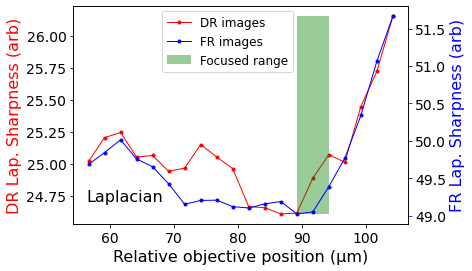

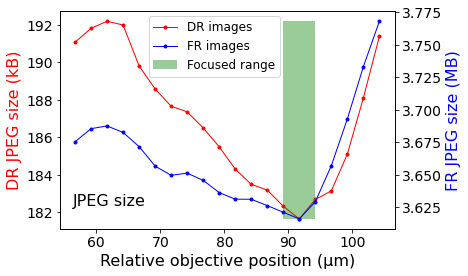

In [15]:
# Plot the resulting heights and sharpnesses

fig, ax1 = plt.subplots()

ax1.plot(x_SD, [x / 1000 for x in Lap_SD], marker = '.',linewidth = 1, color = 'red', label = 'DR images')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('DR Lap. Sharpness (arb)', fontsize=16, color = 'red')
ax1.set_xlabel('Relative objective position (µm)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)


ax2 = ax1.twinx()
ax2.plot(x_HD, [x / 1000 for x in Lap_HD], marker = '.',linewidth = 1, color = 'blue', label = 'FR images')
ax2.set_ylabel('FR Lap. Sharpness (arb)', fontsize=16, color = 'blue')
ax2.tick_params(axis='y', color = 'blue')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.text(0.04, 0.16, 'Laplacian', fontsize = 16, horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)

# A manually judged focused range
focus_1 = 1784/20
focus_2 = 1884/20
ax2.fill_between([focus_1,focus_2], min(Lap_HD)/1000, max(Lap_HD)/1000, facecolor='green', alpha=0.4, label = 'Focused range')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize = 12, loc = (0.265,0.7))
plt.show()

fig, ax1 = plt.subplots()

ax1.plot(x_SD, [x * 1000 for x in size_SD], marker = '.', linewidth = 1, color = 'red', label = 'DR images')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('DR JPEG size (kB)', fontsize=16, color = 'red')
ax1.set_xlabel('Relative objective position (µm)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)


ax2 = ax1.twinx()
ax2.plot(x_HD, size_HD, color = 'blue', marker = '.', linewidth = 1, label = 'FR images')
ax2.set_ylabel('FR JPEG size (MB)',fontsize=16, color = 'blue')
ax2.tick_params(axis='y')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.fill_between([focus_1,focus_2], min(size_HD), max(size_HD), facecolor='green', alpha=0.4, label = 'Focused range')
ax2.text(0.04, 0.16, 'JPEG size', fontsize = 16, horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize = 12, loc = (0.265,0.7)) #, bbox_transform=ax2.transAxes)
plt.show()